In [774]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import zscore, pearsonr, kendalltau,  entropy, spearmanr, linregress, rankdata, ttest_rel, ttest_1samp, ttest_ind
from statsmodels.stats import multitest
import scipy.linalg as la
import itertools
import random
import math
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.stats import multitest

# %% 불용어 리스트 불러오기
# input은 커스텀 불용어
def load_stopword(input_list=None):
    stopwords_f = open('stopwords.txt','rt', encoding='UTF8')
    stopwords_list = stopwords_f.readlines()
    stopwords_f.close()
    stopwords = []
    for words in stopwords_list:
        words = words.replace("\n", '')
        stopwords.append(words.split('/'))
    if input_list:
        for words in input_list: stopwords.append([words[0], words[1]])
    return(stopwords)


    
# %% 구어 태깅
#  구어 태깅
def etri_spokentagger(input, stopwords=False):
    """_ETRI 구어 태깅_

    Args:
        input (_str_): 텍스트
        stopwords (optional): 불용어 제외 여부
            Defaults to True, 기본 불용어 (load_stopword)
            False: 하지 않음
            list: [["단어", "품사]] 형태의 커스텀 불용어
    """
    import urllib3
    import json
    openApiURL = "http://aiopen.etri.re.kr:8000/WiseNLU_spoken"
    accessKey = "9d3f4f60-ac44-43c9-9ae4-a3df0ee86686"  # 개인 accessKey
    analysisCode = "morp"
    requestJson = {
    "argument": {
        "text": input,
        "analysis_code": analysisCode
        }
    }
    http = urllib3.PoolManager()
    response = http.request(
        "POST",
        openApiURL,
        headers={"Content-Type": "application/json; charset=UTF-8", "Authorization" :  accessKey},
        body=json.dumps(requestJson)
    )

    results = response.data.decode('utf-8')
    results = json.loads(results)['return_object']['sentence']
    tagged_results = []
    # 불용어 제거
    if stopwords:
        stopwords_list = load_stopword()
        stopword_tag = []
        for word in stopwords_list:
            if not word[0]: stopword_tag.append(word[1])
    
    # 결과값 저장
    for sent_result in results:
        sentence = []
        for word in sent_result['morp']:
            if stopwords:
                if word['type'] in stopword_tag: pass
                elif [word['lemma'], word['type']] in stopwords_list: pass
                else: sentence.append([word['lemma'], word['type']])
            else: sentence.append([word['lemma'], word['type']])
        tagged_results.extend(sentence)  # rather use extend  
    return(tagged_results)


def process_nv(corpus_fname):
    stopwords = load_stopword()
    corpus = '' #empty sentence
    for sent in open(corpus_fname, 'rt', encoding='UTF8').readlines():
        corpus = corpus + ' ' + sent.strip() #sentence -> remove ' ' \n
    corpus_sentence = corpus.strip().split('.') #이건 각 문장이 str으로 들어간 리스트
    corpus_data = []
    for sent in corpus_sentence:
        tagged_results = etri_spokentagger(sent, stopwords = stopwords)
        tagged_results = np.array(tagged_results)
        tagged_results = tagged_results[0]
        only_nv = ''
        for k in range (len(tagged_results)):
            if tagged_results[k][1] == 'NNG' or tagged_results[k][1] == 'NNP' or tagged_results[k][1] == 'VV' or tagged_results[k][1] == 'VA':
                only_nv = only_nv + ' ' + tagged_results[k][0]
        corpus_data.append(only_nv) #얘는 리스트로 각 문장의 쓸 형태소만 남긴 str이 문장개수만큼 저장
    return(corpus_data)

def process_nv_tagdone(tagged_results): #문장단위로 들어감
    only_nv = ''
    if type(tagged_results) == list:
        for k in range (len(tagged_results)):
            for j in range (len(tagged_results[k])):
                if tagged_results[k][j][1] == 'NNG' or tagged_results[k][j][1] == 'NNP' or tagged_results[k][j][1] == 'VV' or tagged_results[k][j][1] == 'VA':
                    only_nv = only_nv + ' ' + tagged_results[k][j][0]
    return(only_nv)

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [2]:
DATADIR = f'/home/jiunchoi/OFD/OFD_BHV_clean'
groups = [2,3,4,5]
group_clean_txts = np.zeros((4,3), dtype='object')

for group in groups:
      for sub in [1,2,3]:
        groupsub = '0'+str(group)+'0'+str(sub)
        data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/sub-{groupsub}_day2_posthoc.xlsx')
        script = np.array(data_transcript['sentence'])
        clean_txt = np.zeros_like(script, dtype='object')
        for i, sent in enumerate(script):
            if type(sent) == str:
                    clean_txt[i] = etri_spokentagger(sent)
        group_clean_txts[group-2,sub-1] = clean_txt

In [3]:
np.save('group_clean_txts.npy',group_clean_txts)

In [4]:
def extract_recalledidx(group):
    keys = [f'sub-0{group}01',f'sub-0{group}02',f'sub-0{group}03']

    data_transcript = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
    sharedeb = np.array(data_transcript['sharedeb'])
    data_recs = np.array(data_transcript[keys])

    recalled_evidx=[]
    recalled_evs = []
    for i in range(len(sharedeb)):
        count=0
        for j in range(3):
            if (type(data_recs[i,j])==str or np.isnan(data_recs[i,j])==False) and (data_recs[i,j]!=0):
                count+=1
        if count==3:
            if sharedeb[i] not in recalled_evidx:
                recalled_evidx.append(sharedeb[i])
                recalled_evs.append(data_recs[i,:])
    return recalled_evs

# menu_evs = [[8],[10,11,12,14,15,16,17],[3,4],[5,6,7,8,9,10,11,12]] #순서대로 group
# task2_evs = [[9,10,11,12,13,14,15,16],[8,9,18,19],['nan'],[4,14,15,16]]
# task13_evs = []

# for g,group in enumerate(groups):
#     recalled_evs = extract_recalledidx(group)
#     task13_ev = [i for i in range(len(recalled_evs))]
#     subtracted = [x for x in task13_ev if x not in menu_evs[g] and task2_evs[g]]
#     task13_evs.append(subtracted)

def extract_recalledidx_all(group):
    keys = [f'sub-0{group}01',f'sub-0{group}02',f'sub-0{group}03']

    data_transcript = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
    sharedeb = np.array(data_transcript['sharedeb'])
    data_recs = np.array(data_transcript[keys])
    recalled_evidx_all_oh = np.zeros((sharedeb[-1],3))
    recalled_evs_all = np.zeros((sharedeb[-1],3), dtype='object')
    for i in range(len(sharedeb)):
        for j in range(3):
            if (type(data_recs[i,j])==str or np.isnan(data_recs[i,j])==False) and (data_recs[i,j]!=0):
                recalled_evidx_all_oh[int(sharedeb[i])-1,j] = 1
                recalled_evs_all[int(sharedeb[i])-1,j] = str(data_recs[i,j])
    return recalled_evidx_all_oh, recalled_evs_all

In [5]:
menu_evs = [[8],[10,11,12,14,15,16,17],[3,4],[5,6,7,8,9,10,11,12]] #순서대로 group
task2_evs = [[9,10,11,12,13,14,15,16],[8,9,18,19],['nan'],[4,14,15,16]]

group=2
print(menu_evs[group-2])
print(task2_evs[group-2])

[8]
[9, 10, 11, 12, 13, 14, 15, 16]


In [6]:
groups = [2,3,4,5]
tokenbags = np.zeros((len(groups),3,3),dtype='object') #group,sub,cond

for g,group in enumerate(groups):
    recalled_evs = extract_recalledidx(group)

    for e,ev in enumerate(menu_evs[group-2]):
        for sub in [1,2,3]:
            groupsub = '0'+str(group)+'0'+str(sub)
            tmp_sublevel = []
            data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/sub-{groupsub}_day2_posthoc.xlsx')
            recall_segmentation = np.array(data_transcript['segmentation'])
            event_no = str(recalled_evs[ev][sub-1]).split(',') #list of str
            for en in event_no:
                sentfinderidx = np.where(recall_segmentation==int(float(en)))[0]
                for eachsent in group_clean_txts[group-2,sub-1][sentfinderidx]:
                    tmp_sublevel.extend(eachsent)
            tokenbags[g,sub-1,0] = tmp_sublevel

        for e,ev in enumerate(task13_evs[group-2]):
            for sub in [1,2,3]:
                groupsub = '0'+str(group)+'0'+str(sub)
                tmp_sublevel = []
                data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/sub-{groupsub}_day2_posthoc.xlsx')
                recall_segmentation = np.array(data_transcript['segmentation'])
                event_no = str(recalled_evs[ev][sub-1]).split(',') #list of str
                for en in event_no:
                    sentfinderidx = np.where(recall_segmentation==int(float(en)))[0]
                    for eachsent in group_clean_txts[group-2,sub-1][sentfinderidx]:
                        tmp_sublevel.extend(eachsent)
                tokenbags[g,sub-1,1] = tmp_sublevel

    

In [7]:
# 중복제거
tokenbags_clean = np.zeros_like(tokenbags,dtype='object')
for g,group in enumerate(groups):
    for sub in [1,2,3]:
        for cond in range(2):
            tmp_clean = []
            for token in tokenbags[g,sub-1,0]:
                if token not in tmp_clean:
                    tmp_clean.append(token)
            tokenbags_clean[g,sub-1,cond] = tmp_clean

# 겹치는 토큰 개수 세기
tokenbags_count = np.zeros((len(groups),3,3,2)) #group,sub,cond,count/nocount
idx = [0,1,2]
for g,group in enumerate(groups):
    for j in range (3):
        a = idx[j-2]
        b = idx[j-1]
        count = 0
        no_count = 0
        for cond in range(2):
            for word in tokenbags_clean[g,a,cond]:
                if word in tokenbags_clean[g,b,cond]:
                    count+=1
                else:
                    no_count+=1
                tokenbags_count[g,a,cond] = [count,no_count]

In [8]:
samples_for_test = np.zeros((len(groups),3,2)) #group,sub,cond

for cond in range(2):
    for g,group in enumerate(groups):
        samples_for_test[g,:,cond] = tokenbags_count[g,:,cond,0]-tokenbags_count[g,:,cond,1]

In [9]:
from scipy.stats import ttest_rel
values = []
for cond in range(2):
    values.append(samples_for_test[:,:,cond].flatten())

values = np.array(values).T

ttest_rel(values[:,0],values[:,1])

Ttest_relResult(statistic=2.781682992383959, pvalue=0.01785010130760026)

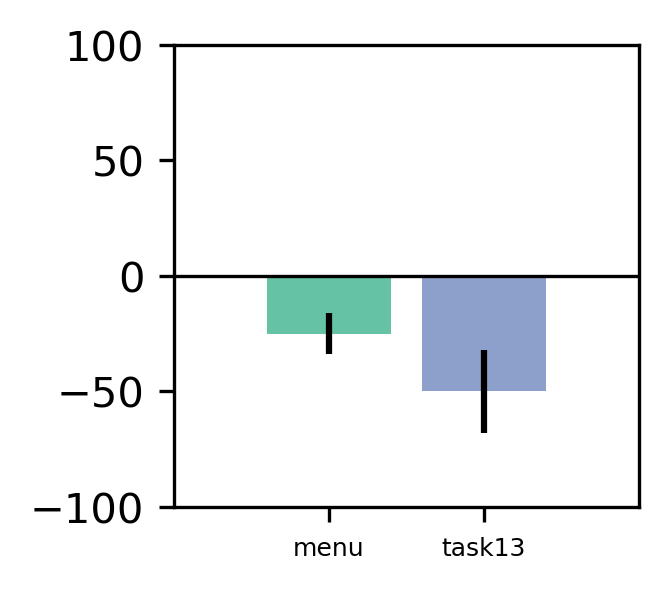

In [10]:
from scipy.stats import sem
import seaborn as sns

colors = sns.color_palette("Set2")

plt.figure(figsize=(2,2), dpi=300)
plt.bar([0,1], [np.mean(values[:,0]), np.mean(values[:,1])], yerr=[sem(values[:,0]), sem(values[:,1])], color=[colors[0], colors[2]], width=0.8)
plt.xlim(-1, 2)
plt.xticks([0,1], ["menu", "task13"], fontsize=6)
# plt.yticks([0.0, 0.05, 0.1])
plt.ylim(-100, 100)
plt.axhline(0.0, c='k', lw=0.8)


# making pairs of text overlapping events

In [11]:
# 이건 컨디션 나눠서 저장한 것
groups = [2,3,4,5]
tokenbags = np.zeros((len(groups),3,2),dtype='object') #group,sub,s/us

for g,group in enumerate(groups):
    recalled_evs = np.array(extract_recalledidx(group))
    for sub in [1,2,3]:
        data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/sub-0{str(group)}0{str(sub)}_day2_posthoc.xlsx')
        recall_segmentation = np.array(data_transcript['segmentation'])
        sub_sharedev_idx = set()
        sub_unsharedev_idx = list(np.arange(1,recall_segmentation[-1]+1))
        for j in range(len(recalled_evs)):
            event_no = str(recalled_evs[j][sub-1]).split(',') #list of str
            for k in event_no:
                cleank = int(float(k))
                try:
                    sub_sharedev_idx.add(cleank)
                    sub_unsharedev_idx.remove(cleank)
                except:
                    pass

        sub_sharedev = np.zeros(int(recall_segmentation[-1]),dtype='object')
        sub_unsharedev = np.zeros(int(recall_segmentation[-1]),dtype='object')

        for e in range(1,int(recall_segmentation[-1])):
            sentfinderidx = np.where(recall_segmentation==e)[0]
            sentlevel = []
            for eachsent in group_clean_txts[group-2,sub-1][sentfinderidx]:
                sentlevel.extend(eachsent)

            if e in sub_sharedev_idx:
                sub_sharedev[e] = sentlevel
            elif e in sub_unsharedev_idx:
                sub_unsharedev[e] = sentlevel
        tokenbags[g,sub-1,0] = sub_sharedev
        tokenbags[g,sub-1,1] = sub_unsharedev


# 중복제거
tokenbags_clean = np.zeros_like(tokenbags,dtype='object')
for g,group in enumerate(groups):
    for sub in [1,2,3]:
        for cond in range(2):
            sub_evs = np.zeros_like(tokenbags[g,sub-1,cond])
            for j in range(len(sub_evs)):
                tmp_clean = []
                if tokenbags[g,sub-1,cond][j] != 0:
                    for token in tokenbags[g,sub-1,cond][j]:
                        if token not in tmp_clean:
                            tmp_clean.append(token)
                    sub_evs[j] = tmp_clean
            tokenbags_clean[g,sub-1,cond] = sub_evs

## 전체 BOW를 만들고 그 안에서 각 이벤트 별 proportion을 계산하기 (원핫벡터로 만들어야하나...)

In [5]:
groups = [2,3,4,5]
tokenbags = np.zeros((len(groups),3),dtype='object') #group,sub,s/us

for g,group in enumerate(groups):
    recalled_evs = np.array(extract_recalledidx(group))
    for sub in [1,2,3]:
        data_transcript = pd.read_excel(f'{DATADIR}/group-0{str(group)}/sub-0{str(group)}0{str(sub)}_day2_posthoc.xlsx')
        recall_segmentation = np.array(data_transcript['segmentation'])
        sub_ev = np.zeros(int(recall_segmentation[-1]),dtype='object')
        for e in range(1,int(recall_segmentation[-1])+1):
            sentfinderidx = np.where(recall_segmentation==e)[0]
            sentlevel = []
            for eachsent in group_clean_txts[group-2,sub-1][sentfinderidx]:
                sentlevel.extend(eachsent)
            sub_ev[e-1] = sentlevel
        tokenbags[g,sub-1] = sub_ev


(6.0, 16.0)

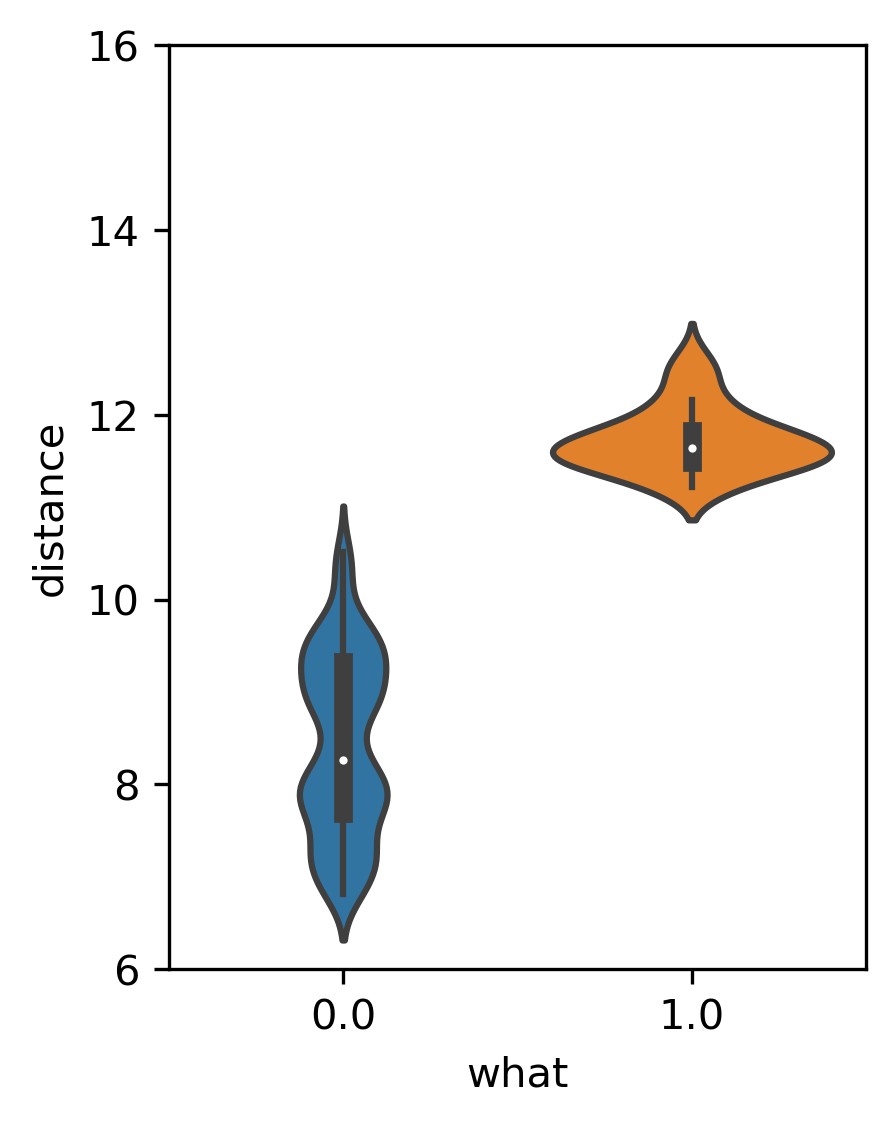

In [276]:
# 1. get the BOW of 1 group
group=2; g=group-2
BOW_of_g2 = []
for sub in [1,2,3]:
    BOW_of_g2.extend(itertools.chain.from_iterable(list(tokenbags[g,sub-1])))
    A = list(set(tuple(i) for i in BOW_of_g2))

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

a = np.arange(len(A)).reshape(-1,1)
oh_encoder = OneHotEncoder()
oh_encoder.fit(a)
oh_labels = oh_encoder.transform(a)
oh_labels = oh_labels.toarray()

# 이제 위에껄 각 참가자 모든 이벤트별로 만들어 (참가자별 3차원으로 만드셈)
group=2; g=0
evBOW_of_g2 = []
for sub in [1,2,3]:
    subn_evtotal_oh = np.zeros((len(oh_labels),len(oh_labels),len(tokenbags[g,sub-1])))
    for ev in range(len(tokenbags[g,sub-1])):
        subn_evn = set(tuple(i) for i in tokenbags[g,sub-1][ev])

        ev_label = []
        for idx,answer in enumerate(A):
            for pair in subn_evn:
                if answer==pair:
                    ev_label.append(idx)
        for tokenidx in ev_label:
            subn_evtotal_oh[tokenidx,tokenidx,ev] = 1
    evBOW_of_g2.append(subn_evtotal_oh)

# shared ev면 그것끼리 mean을 해 (이걸 len(recalled_evs) 길이의 3차원으로 만드셈)
recalled_evs = np.array(extract_recalledidx(group))
event_word_representation = np.zeros_like(recalled_evs, dtype='object')
for e,ev in enumerate(recalled_evs):
    tmp_ev_word_representation = []
    for sub in [1,2,3]:
        event_no = str(recalled_evs[e][sub-1]).split(',') #list of str
        for en in event_no:
            tmp_ev_word_representation.append(evBOW_of_g2[sub-1][:,:,int(float(en)-1)]) #이게 (1465,1465) mat
        subtmp_ev_word_representation = np.array(tmp_ev_word_representation)
        sub_ev_representation = np.mean(subtmp_ev_word_representation, axis=0)
        event_word_representation[e,sub-1] = sub_ev_representation
mean_sharedev_word_representation = np.mean(event_word_representation,axis=1)

# 위의 sharedev에서 가장 비슷한 (본인 구하는데 들어간거 제외) - 매트릭스유사도비교 (euclidean distance/cossim)
recalled_evidx_all_oh, recalled_evs_all = extract_recalledidx_all(group)
recalled_ppls_word_representation = np.zeros_like(recalled_evidx_all_oh, dtype='object')

for i,sharedev in enumerate(recalled_evs_all):
    tmp_shared_word_representation = []
    recalled_ppl = np.where(recalled_evidx_all_oh[i]==1)[0]
    # print(f'{i}번째 이벤트를 {recalled_ppl} 참가자가 리콜하였습니다')
    if len(recalled_ppl) > 0:
        for pplidx in recalled_ppl:
            event_no = str(sharedev[pplidx]).split(',') #list of str
            for en in event_no:
                tmp_shared_word_representation.append(evBOW_of_g2[pplidx][:,:,int(float(en)-1)])
            subtmp_ev_word_representation = np.array(tmp_shared_word_representation)
            sub_ev_representation = np.mean(subtmp_ev_word_representation, axis=0)
            recalled_ppls_word_representation[i,pplidx] = sub_ev_representation

# 이제 한줄짜리 만들거임. 셋 다 리콜한건 nan처리, 셋다리콜하지않은것도 nan처리
mean_recalled_ppls_word_representation = np.zeros(len(recalled_ppls_word_representation),dtype='object')
for ev,rpwr_row in enumerate(recalled_ppls_word_representation):
    recalled_ppl = np.where(recalled_evidx_all_oh[ev]==1)[0]
    if len(recalled_ppl) == 3:
        mean_recalled_ppls_word_representation[ev] = 'nan'
    elif len(recalled_ppl) == 0:
        mean_recalled_ppls_word_representation[ev] = 'nan'
    else:
        mean_recalled_ppls_word_representation[ev] = np.mean(rpwr_row[recalled_evidx_all_oh[ev]==1])


# 이제 셋다리콜한것과 원핫벡터가 제일 비슷한 1,2명 shared event를 찾자! <<근데 계속 나오는 이벤트만 나오는게 좀 걸림
pair_of_sharedev = np.zeros((len(mean_sharedev_word_representation),2), dtype='object')
for m,mswp in enumerate(mean_sharedev_word_representation):
    tmp_distance = np.zeros(len(mean_recalled_ppls_word_representation))
    for mr, mrpwr in enumerate(mean_recalled_ppls_word_representation):
        if type(mswp)==np.ndarray and mrpwr!='nan':
            tmp_distance[mr] = np.linalg.norm(mswp-mrpwr)
    pair_of_sharedev[m,0] = np.where(tmp_distance==np.max(tmp_distance))[0]
    pair_of_sharedev[m,1] = np.max(tmp_distance)

# 그리고 null distri도 만드셈 부트스트랩을 하든지
idxlist = []
for idx,mrpwr in enumerate(mean_recalled_ppls_word_representation):
    if mrpwr=='nan':
        pass
    else:
        idxlist.append(idx)

n_permutation = 1000
permuted_stats = np.zeros((n_permutation)) #save euclidean distance 
for i in range(n_permutation):
    for m,mswr in enumerate(mean_sharedev_word_representation):
        for j in pair_of_sharedev[m,0]:
            try:
                print(idxlist.remove(j))
            except:
                pass
    nonpair_idx = random.choice(idxlist)
    permuted_stats[i] = np.linalg.norm(mswr-mean_recalled_ppls_word_representation[nonpair_idx])

# 위의 짓을 겁나많이해서 tmp_distance의 가능한 분포가 바이올린플롯으로 있고
peridx = np.zeros_like(permuted_stats)
pairidx = np.ones_like(pair_of_sharedev[:,1])
a = np.vstack((peridx,permuted_stats))
b = np.vstack((pairidx,pair_of_sharedev[:,1].astype('float')))
c = np.hstack((a,b)).T
df = pd.DataFrame(c, columns=['what','distance'],dtype='float')

plt.figure(figsize=(3,4),dpi=300)
sns.violinplot(data=df, x='what',y='distance')
plt.ylim(6,16)

# 그럼에도 불구하고 내가 만들어준 페어는 토큰원핫벡터의 유사도가 sig하게 높다는 걸 보임
t_stat, p_values = ttest_ind(permuted_stats, pair_of_sharedev[:,1].astype('float'))
print(p_values<0.000001)

# # 이제 쌍을 만들어주고 그에 해당하는 pattern을 불러옴
# 위의  np.where(tmp_distance==np.max(tmp_distance))[0])인 sharedeb상의 인덱스를 가지고
# 다시 recalled_evs_all에서 어떤 참가자의 recall이었는지 찾은다음에 
# 거기에 해당하는 neural pattern을 불러와서 time mean을 함 (이게 control) (roi는 주요roi일단씀)
# mswp에 해당한 이벤트의 패턴들도 참가자별로 각각 다 불러옴
# 맨 위 인덱스에 해당하는 사람이 누군지 빼놓고
# 해당하는 사람과 나머지 둘의 shared ev에서의 ispc 구함
# 그리고 맨처음에 구한 다른 이벤트인데 해당하는 사람의 패턴이랑 나머지 둘의 unsharedev에서의 ispc 구함
# 이 둘 중 뭐가 더 값이 큰지 확인 (전자가 더 크지 않으면 접어야함)



# 그룹별로 다 합시다

In [425]:
dfBAG = []
posh = []
for g,group in enumerate([2,3,4,5]):
    BOW_of_group = []
    for sub in [1,2,3]:
        BOW_of_group.extend(itertools.chain.from_iterable(list(tokenbags[g,sub-1])))
        A = list(set(tuple(i) for i in BOW_of_group))

    a = np.arange(len(A)).reshape(-1,1)
    oh_encoder = OneHotEncoder()
    oh_encoder.fit(a)
    oh_labels = oh_encoder.transform(a)
    oh_labels = oh_labels.toarray()
    print(group, oh_labels.shape, 'checkpoint1')

    # 이제 위에껄 각 참가자 모든 이벤트별로 만들어 (참가자별 3차원으로 만드셈)
    evBOW_of_group = []
    for sub in [1,2,3]:
        subn_evtotal_oh = np.zeros((len(oh_labels),len(oh_labels),len(tokenbags[g,sub-1])))
        for ev in range(len(tokenbags[g,sub-1])):
            subn_evn = set(tuple(i) for i in tokenbags[g,sub-1][ev])

            ev_label = []
            for idx,answer in enumerate(A):
                for pair in subn_evn:
                    if answer==pair:
                        ev_label.append(idx)
            for tokenidx in ev_label:
                subn_evtotal_oh[tokenidx,tokenidx,ev] = 1
        evBOW_of_group.append(subn_evtotal_oh)
    print(group, evBOW_of_group[0].shape, evBOW_of_group[1].shape, evBOW_of_group[2].shape, 'checkpoint2')

    # shared ev면 그것끼리 mean을 해 (이걸 len(recalled_evs) 길이의 3차원으로 만드셈)
    recalled_evs = np.array(extract_recalledidx(group))
    event_word_representation = np.zeros_like(recalled_evs, dtype='object')
    for e,ev in enumerate(recalled_evs):
        tmp_ev_word_representation = []
        for sub in [1,2,3]:
            event_no = str(ev[sub-1]).split(',') #list of str
            for en in event_no:
                tmp_ev_word_representation.append(evBOW_of_group[sub-1][:,:,int(float(en)-1)]) #이게 (1465,1465) mat
            subtmp_ev_word_representation = np.array(tmp_ev_word_representation)
            sub_ev_representation = np.mean(subtmp_ev_word_representation, axis=0)
            event_word_representation[e,sub-1] = sub_ev_representation
    mean_sharedev_word_representation = np.mean(event_word_representation,axis=1)
    print(group, recalled_evs.shape,mean_sharedev_word_representation.shape, 'checkpoint3')

    # 위의 sharedev에서 가장 비슷한 (본인 구하는데 들어간거 제외) - 매트릭스유사도비교 (euclidean distance/cossim)
    recalled_evidx_all_oh, recalled_evs_all = extract_recalledidx_all(group)
    recalled_ppls_word_representation = np.zeros_like(recalled_evidx_all_oh, dtype='object')

    for i,sharedev in enumerate(recalled_evs_all):
        tmp_shared_word_representation = []
        recalled_ppl = np.where(recalled_evidx_all_oh[i]==1)[0]
        # print(f'{i}번째 이벤트를 {recalled_ppl} 참가자가 리콜하였습니다')
        if len(recalled_ppl) > 0:
            for pplidx in recalled_ppl:
                event_no = str(sharedev[pplidx]).split(',') #list of str
                for en in event_no:
                    tmp_shared_word_representation.append(evBOW_of_group[pplidx][:,:,int(float(en)-1)])
                subtmp_ev_word_representation = np.array(tmp_shared_word_representation)
                sub_ev_representation = np.mean(subtmp_ev_word_representation, axis=0)
                recalled_ppls_word_representation[i,pplidx] = sub_ev_representation
    print(group, 'checkpoint4')

    # 이제 한줄짜리 만들거임. 셋 다 리콜한건 nan처리, 셋다리콜하지않은것도 nan처리
    mean_recalled_ppls_word_representation = np.zeros(len(recalled_ppls_word_representation),dtype='object')
    for ev,rpwr_row in enumerate(recalled_ppls_word_representation):
        recalled_ppl = np.where(recalled_evidx_all_oh[ev]==1)[0]
        if len(recalled_ppl) == 3:
            mean_recalled_ppls_word_representation[ev] = 'nan'
        elif len(recalled_ppl) == 0:
            mean_recalled_ppls_word_representation[ev] = 'nan'
        else:
            mean_recalled_ppls_word_representation[ev] = np.mean(rpwr_row[recalled_evidx_all_oh[ev]==1])
    print(group, 'checkpoint5')

    # 이제 셋다리콜한것과 원핫벡터가 제일 비슷한 1,2명 shared event를 찾자! <<근데 계속 나오는 이벤트만 나오는게 좀 걸림
    pair_of_sharedev = np.zeros((len(mean_sharedev_word_representation),2), dtype='object')
    for m,mswp in enumerate(mean_sharedev_word_representation):
        tmp_cossim = np.zeros(len(mean_recalled_ppls_word_representation))
        for mr, mrpwr in enumerate(mean_recalled_ppls_word_representation):
            if type(mswp)==np.ndarray and mrpwr!='nan':
                tmp_cossim[mr] = cosine_similarity(mswp-mrpwr)
        pair_of_sharedev[m,0] = np.where(tmp_cossim==np.max(tmp_distance))[0]
        pair_of_sharedev[m,1] = np.max(tmp_cossim)
    posh.append(pair_of_sharedev[:,0])
    print(group, 'checkpoint6')

    # # 그리고 null distri도 만드셈 부트스트랩을 하든지
    # idxlist = []
    # for idx,mrpwr in enumerate(mean_recalled_ppls_word_representation):
    #     if mrpwr=='nan':
    #         pass
    #     else:
    #         idxlist.append(idx)

    # n_permutation = 1000
    # permuted_stats = np.zeros((n_permutation)) #save euclidean distance 
    # for i in range(n_permutation):
    #     for m,mswr in enumerate(mean_sharedev_word_representation):
    #         for j in pair_of_sharedev[m,0]:
    #             try:
    #                 print(idxlist.remove(j))
    #             except:
    #                 pass
    #     nonpair_idx = random.choice(idxlist)
    #     permuted_stats[i] = np.linalg.norm(mswr-mean_recalled_ppls_word_representation[nonpair_idx])
    # print(group, 'checkpoint7')

    # # 위의 짓을 겁나많이해서 tmp_distance의 가능한 분포가 바이올린플롯으로 있고
    # peridx = np.zeros_like(permuted_stats)
    # pairidx = np.ones_like(pair_of_sharedev[:,1])
    # a = np.vstack((peridx,permuted_stats))
    # b = np.vstack((pairidx,pair_of_sharedev[:,1].astype('float')))
    # c = np.hstack((a,b)).T
    # df = pd.DataFrame(c, columns=['what','distance'],dtype='float')
    # dfBAG.append(df)
    # print(group, 'checkpoint8')
    # time.sleep(1)


2 (1484, 1484) checkpoint1
2 (1484, 1484, 69) (1484, 1484, 27) (1484, 1484, 27) checkpoint2
2 (31, 3) (31,) checkpoint3
2 checkpoint4
2 checkpoint5


/tmp/ipykernel_10837/1653104323.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


2 checkpoint6
3 (952, 952) checkpoint1
3 (952, 952, 31) (952, 952, 42) (952, 952, 42) checkpoint2
3 (27, 3) (27,) checkpoint3
3 checkpoint4
3 checkpoint5


/tmp/ipykernel_10837/1653104323.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


3 checkpoint6
4 (818, 818) checkpoint1
4 (818, 818, 30) (818, 818, 39) (818, 818, 31) checkpoint2
4 (10, 3) (10,) checkpoint3
4 checkpoint4
4 checkpoint5


/tmp/ipykernel_10837/1653104323.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


4 checkpoint6
5 (773, 773) checkpoint1
5 (773, 773, 26) (773, 773, 20) (773, 773, 26) checkpoint2
5 (22, 3) (22,) checkpoint3
5 checkpoint4
5 checkpoint5


/tmp/ipykernel_10837/1653104323.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


5 checkpoint6


# 위에꺼 잘못했음요
* 매트릭스말고 벡터로
* 유클리디안 말고 코스심으로

In [948]:
dfBAG = []
posh = []
for g,group in enumerate([2,3,4,5]):
    BOW_of_group = []
    for sub in [1,2,3]:
        BOW_of_group.extend(itertools.chain.from_iterable(list(tokenbags[g,sub-1])))
        A = list(set(tuple(i) for i in BOW_of_group))

    evBOW_of_group = []
    for sub in [1,2,3]:
        subn_evtotal_oh = np.zeros((len(A),len(tokenbags[g,sub-1])))
        for ev in range(len(tokenbags[g,sub-1])):
            subn_evn = set(tuple(i) for i in tokenbags[g,sub-1][ev])

            ev_label = []
            for idx,answer in enumerate(A):
                for pair in subn_evn:
                    if answer==pair:
                        ev_label.append(idx)
            for tokenidx in ev_label:
                subn_evtotal_oh[tokenidx,ev] = 1
        evBOW_of_group.append(subn_evtotal_oh)
    print(group, evBOW_of_group[0].shape, evBOW_of_group[1].shape, evBOW_of_group[2].shape, 'checkpoint2')

    # shared ev면 그것끼리 mean을 해 (이걸 len(recalled_evs) 길이의 3차원으로 만드셈)
    recalled_evs = np.array(extract_recalledidx(group))
    event_word_representation = np.zeros_like(recalled_evs, dtype='object')
    for e,ev in enumerate(recalled_evs):
        tmp_ev_word_representation = []
        for sub in [1,2,3]:
            event_no = str(ev[sub-1]).split(',') #list of str
            for en in event_no:
                tmp_ev_word_representation.append(evBOW_of_group[sub-1][:,int(float(en)-1)]) #이게 (1465,) vector
            subtmp_ev_word_representation = np.array(tmp_ev_word_representation)
            sub_ev_representation = np.mean(subtmp_ev_word_representation, axis=0)
            event_word_representation[e,sub-1] = sub_ev_representation
    mean_sharedev_word_representation = np.mean(event_word_representation,axis=1)
    print(group, recalled_evs.shape, mean_sharedev_word_representation.shape, 'checkpoint3')

    # 위의 sharedev에서 가장 비슷한 (본인 구하는데 들어간거 제외) - 매트릭스유사도비교 (euclidean distance/cossim)
    recalled_evidx_all_oh, recalled_evs_all = extract_recalledidx_all(group)
    recalled_ppls_word_representation = np.zeros_like(recalled_evidx_all_oh, dtype='object')

    for i,sharedev in enumerate(recalled_evs_all):
        tmp_shared_word_representation = []
        recalled_ppl = np.where(recalled_evidx_all_oh[i]==1)[0]
        # print(f'{i}번째 이벤트를 {recalled_ppl} 참가자가 리콜하였습니다')
        if len(recalled_ppl) > 0:
            for pplidx in recalled_ppl:
                event_no = str(sharedev[pplidx]).split(',') #list of str
                for en in event_no:
                    tmp_shared_word_representation.append(evBOW_of_group[pplidx][:,int(float(en)-1)])
                subtmp_ev_word_representation = np.array(tmp_shared_word_representation)
                sub_ev_representation = np.mean(subtmp_ev_word_representation, axis=0)
                recalled_ppls_word_representation[i,pplidx] = sub_ev_representation
    print(group, 'checkpoint4')

    # 이제 한줄짜리 만들거임. 셋 다 리콜한건 nan처리, 셋다리콜하지않은것도 nan처리
    mean_recalled_ppls_word_representation = np.zeros(len(recalled_ppls_word_representation),dtype='object')
    for ev,rpwr_row in enumerate(recalled_ppls_word_representation):
        recalled_ppl = np.where(recalled_evidx_all_oh[ev]==1)[0]
        if len(recalled_ppl) == 3:
            mean_recalled_ppls_word_representation[ev] = 'nan'
        elif len(recalled_ppl) == 0:
            mean_recalled_ppls_word_representation[ev] = 'nan'
        else:
            mean_recalled_ppls_word_representation[ev] = np.mean(rpwr_row[recalled_evidx_all_oh[ev]==1])
    print(group, 'checkpoint5')

    # 이제 셋다리콜한것과 원핫벡터가 제일 비슷한 1,2명 shared event를 찾자! <<근데 계속 나오는 이벤트만 나오는게 좀 걸림
    pair_of_sharedev = np.zeros((len(mean_sharedev_word_representation),2), dtype='object')
    for m,mswp in enumerate(mean_sharedev_word_representation):
        tmp_cossim = np.zeros(len(mean_recalled_ppls_word_representation))
        for mr, mrpwr in enumerate(mean_recalled_ppls_word_representation):
            if type(mswp)==np.ndarray and mrpwr!='nan':
                tmp_cossim[mr] = cos_similarity(mswp,mrpwr)

        candid = np.where(tmp_cossim == np.max(tmp_cossim))[0]
        ball = 1
        while ball==1:
            for r, reac in enumerate(recalled_evs_all[candid]):
                for s in range(3):
                    for cand in candid:
                        testee = str(reac[s]).split(',')
                        for tt in testee:
                            for res in (recalled_evs):
                                ev = str(res[s]).split(',')
                                for e in ev:
                                    if int(float(tt)) == int(float(e)):
                                        tmp_cossim[cand] = 0
                                    else:
                                        candid = np.where(tmp_cossim == np.max(tmp_cossim))[0]
                                        ball = 0
        pair_of_sharedev[m,0] = candid
        pair_of_sharedev[m,1] = tmp_cossim[candid]
    posh.append(pair_of_sharedev[:,0])
    print(group, 'checkpoint6')

    # 그리고 null distri도 만드셈 부트스트랩을 하든지
    idxlist = []
    for idx,mrpwr in enumerate(mean_recalled_ppls_word_representation):
        if mrpwr=='nan':
            pass
        else:
            idxlist.append(idx)

    n_permutation = 1000
    permuted_stats = np.zeros((n_permutation)) #save euclidean distance 
    for i in range(n_permutation):
        for m,mswr in enumerate(mean_sharedev_word_representation):
            for j in pair_of_sharedev[m,0]:
                try:
                    idxlist.remove(j)
                except:
                    pass
        nonpair_idx = random.choice(idxlist)
        permuted_stats[i] = cos_similarity(mswr,mean_recalled_ppls_word_representation[nonpair_idx])
    print(group, 'checkpoint7')

    # 위의 짓을 겁나많이해서 tmp_distance의 가능한 분포가 바이올린플롯으로 있고
    peridx = np.zeros_like(permuted_stats)
    pairidx = np.ones_like(pair_of_sharedev[:,1])
    a = np.vstack((peridx,permuted_stats))
    try:
        b = np.vstack((pairidx, pair_of_sharedev[:,1].astype('float')))
    except:
            pair_of_sharedev_dist = np.zeros(len(pair_of_sharedev[:,1]))
            for p,pose in enumerate(pair_of_sharedev[:,1]):
                if len(pose)>1:
                    pair_of_sharedev_dist[p] = pose[0]
                else:
                    pair_of_sharedev_dist[p] = pose
            b = np.vstack((pairidx, pair_of_sharedev_dist))

    c = np.hstack((a,b)).T
    df = pd.DataFrame(c, columns=['what','distance'],dtype='float')
    dfBAG.append(df)
    print(group, 'checkpoint8')
    # time.sleep(1)


2 (1484, 69) (1484, 27) (1484, 27) checkpoint2
2 (31, 3) (31,) checkpoint3
2 checkpoint4
2 checkpoint5


/tmp/ipykernel_10837/582355612.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


2 checkpoint6


/tmp/ipykernel_10837/582355612.py:102: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mrpwr=='nan':


2 checkpoint7
2 checkpoint8
3 (952, 31) (952, 42) (952, 42) checkpoint2
3 (27, 3) (27,) checkpoint3
3 checkpoint4
3 checkpoint5


/tmp/ipykernel_10837/582355612.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


3 checkpoint6
3 checkpoint7
3 checkpoint8


/tmp/ipykernel_10837/582355612.py:102: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mrpwr=='nan':


4 (818, 30) (818, 39) (818, 31) checkpoint2
4 (10, 3) (10,) checkpoint3
4 checkpoint4
4 checkpoint5
4 checkpoint6


/tmp/ipykernel_10837/582355612.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':
/tmp/ipykernel_10837/582355612.py:102: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mrpwr=='nan':


4 checkpoint7
4 checkpoint8
5 (773, 26) (773, 20) (773, 26) checkpoint2
5 (22, 3) (22,) checkpoint3
5 checkpoint4
5 checkpoint5


/tmp/ipykernel_10837/582355612.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


5 checkpoint6


/tmp/ipykernel_10837/582355612.py:102: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mrpwr=='nan':


5 checkpoint7
5 checkpoint8


In [990]:
for g,group in enumerate([2,3]):
    BOW_of_group = []
    for sub in [1,2,3]:
        BOW_of_group.extend(itertools.chain.from_iterable(list(tokenbags[g,sub-1])))
        A = list(set(tuple(i) for i in BOW_of_group))

    evBOW_of_group = []
    for sub in [1,2,3]:
        subn_evtotal_oh = np.zeros((len(A),len(tokenbags[g,sub-1])))
        for ev in range(len(tokenbags[g,sub-1])):
            subn_evn = set(tuple(i) for i in tokenbags[g,sub-1][ev])

            ev_label = []
            for idx,answer in enumerate(A):
                for pair in subn_evn:
                    if answer==pair:
                        ev_label.append(idx)
            for tokenidx in ev_label:
                subn_evtotal_oh[tokenidx,ev] = 1
        evBOW_of_group.append(subn_evtotal_oh)
    print(group, evBOW_of_group[0].shape, evBOW_of_group[1].shape, evBOW_of_group[2].shape, 'checkpoint2')

    # shared ev면 그것끼리 mean을 해 (이걸 len(recalled_evs) 길이의 3차원으로 만드셈)
    recalled_evs = np.array(extract_recalledidx(group))
    event_word_representation = np.zeros_like(recalled_evs, dtype='object')
    for e,ev in enumerate(recalled_evs):
        tmp_ev_word_representation = []
        for sub in [1,2,3]:
            event_no = str(ev[sub-1]).split(',') #list of str
            for en in event_no:
                tmp_ev_word_representation.append(evBOW_of_group[sub-1][:,int(float(en)-1)]) #이게 (1465,) vector
            subtmp_ev_word_representation = np.array(tmp_ev_word_representation)
            sub_ev_representation = np.mean(subtmp_ev_word_representation, axis=0)
            event_word_representation[e,sub-1] = sub_ev_representation
    mean_sharedev_word_representation = np.mean(event_word_representation,axis=1)
    print(group, recalled_evs.shape, mean_sharedev_word_representation.shape, 'checkpoint3')

    # 위의 sharedev에서 가장 비슷한 (본인 구하는데 들어간거 제외) - 매트릭스유사도비교 (euclidean distance/cossim)
    recalled_evidx_all_oh, recalled_evs_all = extract_recalledidx_all(group)
    recalled_ppls_word_representation = np.zeros_like(recalled_evidx_all_oh, dtype='object')

    for i,sharedev in enumerate(recalled_evs_all):
        tmp_shared_word_representation = []
        recalled_ppl = np.where(recalled_evidx_all_oh[i]==1)[0]
        # print(f'{i}번째 이벤트를 {recalled_ppl} 참가자가 리콜하였습니다')
        if len(recalled_ppl) > 0:
            for pplidx in recalled_ppl:
                event_no = str(sharedev[pplidx]).split(',') #list of str
                for en in event_no:
                    tmp_shared_word_representation.append(evBOW_of_group[pplidx][:,int(float(en)-1)])
                subtmp_ev_word_representation = np.array(tmp_shared_word_representation)
                sub_ev_representation = np.mean(subtmp_ev_word_representation, axis=0)
                recalled_ppls_word_representation[i,pplidx] = sub_ev_representation
    print(group, 'checkpoint4')

    # 이제 한줄짜리 만들거임. 셋 다 리콜한건 nan처리, 셋다리콜하지않은것도 nan처리
    mean_recalled_ppls_word_representation = np.zeros(len(recalled_ppls_word_representation),dtype='object')
    for ev,rpwr_row in enumerate(recalled_ppls_word_representation):
        recalled_ppl = np.where(recalled_evidx_all_oh[ev]==1)[0]
        if len(recalled_ppl) == 3:
            mean_recalled_ppls_word_representation[ev] = 'nan'
        elif len(recalled_ppl) == 0:
            mean_recalled_ppls_word_representation[ev] = 'nan'
        else:
            mean_recalled_ppls_word_representation[ev] = np.mean(rpwr_row[recalled_evidx_all_oh[ev]==1])
    print(group, 'checkpoint5')

    # 이제 셋다리콜한것과 원핫벡터가 제일 비슷한 1,2명 shared event를 찾자! <<근데 계속 나오는 이벤트만 나오는게 좀 걸림
    pair_of_sharedev = np.zeros((len(mean_sharedev_word_representation),2), dtype='object')
    for m,mswp in enumerate(mean_sharedev_word_representation):
        tmp_cossim = np.zeros(len(mean_recalled_ppls_word_representation))
        for mr, mrpwr in enumerate(mean_recalled_ppls_word_representation):
            if type(mswp)==np.ndarray and mrpwr!='nan':
                tmp_cossim[mr] = cos_similarity(mswp,mrpwr)

        candid = np.where(tmp_cossim == np.max(tmp_cossim))[0]
        ball = 1
        while ball==1:
            for r, reac in enumerate(recalled_evs_all[candid]):
                for s in range(3):
                    for cand in candid:
                        testee = str(reac[s]).split(',')
                        for tt in testee:
                            for res in (recalled_evs):
                                ev = str(res[s]).split(',')
                                for e in ev:
                                    if int(float(tt)) == int(float(e)):
                                        tmp_cossim[cand] = 0
                                    else:
                                        candid = np.where(tmp_cossim == np.max(tmp_cossim))[0]
                                        ball = 0
                                        # 중간에 왜 0이 들어가는지 너무 알 수가 없다....
        pair_of_sharedev[m,0] = candid
        pair_of_sharedev[m,1] = tmp_cossim[candid]
    posh.append(pair_of_sharedev[:,0])

2 (1484, 69) (1484, 27) (1484, 27) checkpoint2
2 (31, 3) (31,) checkpoint3
2 checkpoint4
2 checkpoint5
2 120 [4] 0.8497344658584243
2 120 [4] 0.8515414932962598
2 120 [8] 0.7116857550470919
2 120 [12] 0.7232074244931102
2 120 [26] 0.8270173206764944
2 120 [11] 0.7108812270601536
2 120 [11] 0.6978438466147753
2 120 [11] 0.6820343452622196
2 120 [8] 0.622491078305826
2 120 [47] 0.8248796431216391


/tmp/ipykernel_10837/978057250.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


2 120 [45] 0.9608075336629832
2 120 [55] 0.6978066436729884
2 120 [55] 0.6820233291619473
2 120 [55] 0.6820233291619473
2 120 [55] 0.7132073612558519
2 120 [8] 0.5658257193722105
2 120 [46] 0.5188575110412078
2 120 [61] 0.9888977396717978
2 120 [61] 0.9864915006202397
2 120 [65 66 67 68] 0.9803142179291978
2 120 [65 66 67 68] 0.9803142179291978
2 120 [48] 0.9944948163903323
2 120 [48] 0.9944948163903323
2 120 [11] 0.6101644694926719
2 120 [119] 0.7848787887610185
2 120 [11] 0.5726005379537026
2 120 [11] 0.5311777581714512
2 120 [98] 0.9563307885746878
2 120 [11] 0.5624275222798238
2 120 [102] 0.5872473779650063
2 120 [102] 0.5872473779650063
3 (952, 31) (952, 42) (952, 42) checkpoint2
3 (27, 3) (27,) checkpoint3
3 checkpoint4
3 checkpoint5
3 212 [5 6] 0.9890543087267192
3 212 [44] 0.6145128787434738
3 212 [44] 0.6145128787434738
3 212 [12] 0.9901870829754996
3 212 [54] 0.9146208434762872
3 212 [54] 0.9314100904525723
3 212 [60 62] 0.983130111047757
3 212 [65 67] 0.9902160085059215
3 21

/tmp/ipykernel_10837/978057250.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type(mswp)==np.ndarray and mrpwr!='nan':


3 212 [96] 0.7961735163442526
3 212 [96] 0.8099111124191429
3 212 [102] 0.9908878872092576
3 212 [104] 0.9898396706537996
3 212 [109] 0.9644009747529624
3 212 [109] 0.9644009747529624
3 212 [109] 0.95533784986371
3 212 [111] 0.9873053266323262
3 212 [111] 0.9888632139020508
3 212 [181] 0.9515354859881379
3 212 [181] 0.9515354859881379
3 212 [197] 0.9878619985390173
3 212 [204] 0.5334714296825672
3 212 [207] 0.8237462304747925
3 212 [163] 0.4967465132001715
3 212 [163] 0.4967465132001715


214 -26.343943851661447 2.0908386951810504e-141 True


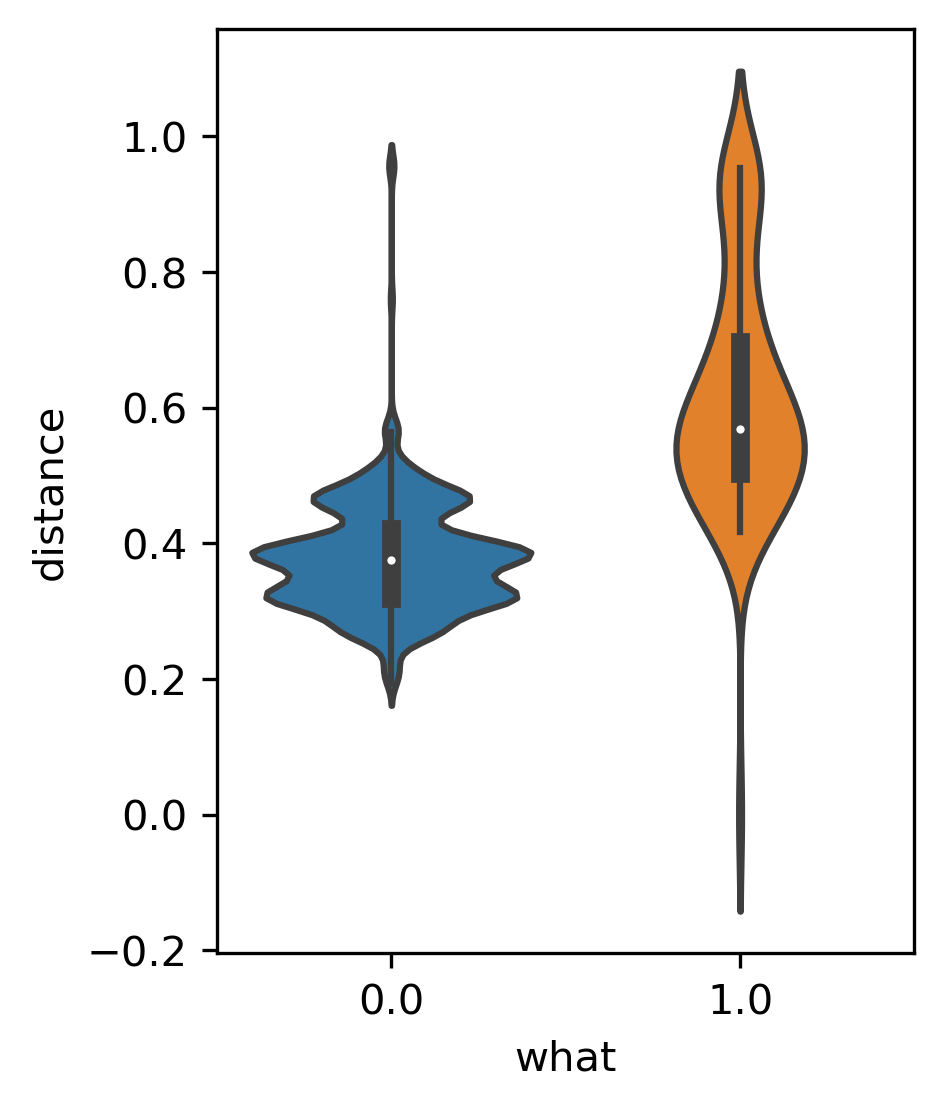

In [991]:
colors = sns.color_palette("Set2")
plt.figure(figsize=(3,4),dpi=300)
sns.violinplot(data= pd.concat(dfBAG), x='what',y='distance', pallette=colors)
# plt.ylim(1,17)

# 그럼에도 불구하고 내가 만들어준 페어는 토큰원핫벡터의 유사도가 sig하게 높다는 걸 보임
df = pd.concat(dfBAG)
t_stat, p_values = ttest_ind(df.loc[df['what']==0]['distance'], df.loc[df['what']==1]['distance'])
print(i+2, t_stat, p_values, p_values<0.000001)

# pattern similarity를 계산합시다

In [556]:
def get_boundary(group,sub):
    groupsub = group+sub
    word_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_AUDIO/derivatives/group-{group}/sub-{groupsub}_run-1_day2_words.xlsx')
    posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV/group-{group}/sub-{groupsub}_day2_posthoc.xlsx')
    # word_data.keys() = start, end, word
    # posthoc_data.keys() = sentence, segmentation, description, tag
    words = word_data['word']
    start = word_data['start']
    end = word_data['end']
    sentstartend = []
    eventstartend = []

    segcol = posthoc_data['segmentation']

    # 아래가 concat의 원리
    tmpstart = start[0]
    for i in range (len(words)-1):
        if '.' in str(words[i]) or ',' in str(words[i]) or '었고' in str(words[i]) or '것 같고' in str(words[i]) or '지고' in str(words[i]) or '는데' in str(words[i]) or '근데' in str(words[i]) or '그리고' in str(words[i]) or '그러고' in str(words[i]) or '됐고' in str(words[i]) or '했고' in str(words[i]): 
            tmpend = end[i]
            sentstartend.append([tmpstart,tmpend])
            tmpstart = start[i+1]
    tmpend = end[len(words)-1]
    sentstartend.append([tmpstart,tmpend])

    tmpstart = sentstartend[0][0]
    boundary = []
    for i in range (len(segcol)-1):
        if segcol[i] != segcol[i+1]:
            boundary.append(sentstartend[i][1])            
            eventstartend.append([tmpstart,sentstartend[i][1]])
            tmpstart = sentstartend[i+1][0]
    tmpend = sentstartend[-1][1]
    eventstartend.append([tmpstart,tmpend])    
    
    return eventstartend, boundary

def get_boundary2(group,sub,run):
    groupsub = '0'+str(group)+'0'+str(sub)
    word_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_AUDIO/derivatives/group-0{group}/sub-{groupsub}_run-{run}_day2_words.xlsx')
    posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{group}/sub-{groupsub}_day2_posthoc.xlsx')
    # word_data.keys() = start, end, word
    # posthoc_data.keys() = sentence, segmentation, description, tag
    words = word_data['word']
    start = word_data['start']
    end = word_data['end']
    sentstartend = []
    eventstartend = []
    endidx = [0]
    for t in range (len(posthoc_data['Unnamed: 0'])-1):
        if posthoc_data['Unnamed: 0'][t]+1 != posthoc_data['Unnamed: 0'][t+1]:
            endidx.append(t)
    endidx.append(len(posthoc_data['Unnamed: 0'])-1)
    if len(endidx)>2:
        segcol = np.array(posthoc_data['segmentation'][endidx[run-1]+1:endidx[run]+1])
    else:
        segcol = np.array(posthoc_data['segmentation'])

    tmpstart = start[0]
    for i in range (len(words)-1):
        if '.' in str(words[i]) or ',' in str(words[i]) or '었고' in str(words[i]) or '것 같고' in str(words[i]) or '지고' in str(words[i]) or '는데' in str(words[i]) or '근데' in str(words[i]) or '그리고' in str(words[i]) or '그러고' in str(words[i]) or '됐고' in str(words[i]) or '했고' in str(words[i]): 
            tmpend = end[i]
            sentstartend.append([tmpstart,tmpend])
            tmpstart = start[i+1]
    tmpend = end[len(words)-1]
    sentstartend.append([tmpstart,tmpend])

    # working for subs with only 1 run
    tmpstart = sentstartend[0][0]
    for i in range (len(segcol)-1):
        if segcol[i] != segcol[i+1]:     
            tmpend = sentstartend[i][1]     
            eventstartend.append([tmpstart,tmpend])
            tmpstart = sentstartend[i+1][0]
    tmpend = sentstartend[len(segcol)-1][1]
    eventstartend.append([tmpstart,tmpend]) 
    
    return eventstartend

def r2z(r):
    return 0.5 * (np.log(1 + r) - np.log(1 - r))

In [374]:
import nibabel as nib

from scipy.stats import zscore, pearsonr, kendalltau,  entropy, spearmanr, linregress, rankdata, ttest_rel, ttest_1samp, ttest_ind
import scipy.linalg as la

MASKDIR = '/home/jiunchoi/OFD/source/'
DATADIR = '/home/jiunchoi/OFD/OFD_DATA/derivatives/'
PMC_labels = [153,154,175,176]
 
BN_atlas = nib.load(f'{MASKDIR}BNA_3mm_atlas.nii').get_fdata()
PMC_labels = [153,154,175,176]
PMC_mask = np.zeros(BN_atlas.shape)
for r in PMC_labels:
    PMC_mask[BN_atlas==r] = 1

group='03'
run = '1'
task = 'RECALL'
recall_fmri = {}
for sub in [1,2,3]:
    groupsub = group+'0'+str(sub)
    fmri_data = nib.load(f'{DATADIR}sub-{groupsub}/preprocessed/sub-{groupsub}_{task}_{run}_sc_dt_sm.nii.gz').get_fdata()
    fmri_data = fmri_data[PMC_mask==1, :].T #(Time, Voxels)
    fmri_data = zscore(fmri_data, axis=0)
    fmri_data = np.nan_to_num(fmri_data)
    recall_fmri[sub] = fmri_data

In [519]:
MASKDIR = '/home/jiunchoi/OFD/source/'
DATADIR = '/home/jiunchoi/OFD/OFD_DATA/derivatives/'
BN_atlas = nib.load(f'{MASKDIR}BNA_3mm_atlas.nii').get_fdata()

def load_brain(group,sub,run):
    task = 'RECALL'
    BN_parcels = np.zeros((246), dtype='object')
    groupsub = '0'+str(group)+'0'+str(sub)
    fmri_data = nib.load(f'{DATADIR}sub-{groupsub}/preprocessed/sub-{groupsub}_{task}_{run}_sc_dt_sm.nii.gz').get_fdata()
    for roi in range (1,246+1):
        roi_data = fmri_data[BN_atlas==roi, :].T #(Time, Voxels)
        roi_data = zscore(roi_data, axis=0)
        roi_data = np.nan_to_num(roi_data)
        BN_parcels[roi-1] = roi_data
    return BN_parcels

In [520]:
groups=[2,3,4,5]
group_brain = np.zeros((len(groups),3), dtype='object')

for group in groups:
    for sub in [1,2,3]:
        sub_brain = []
        if (group==2 and sub==1):
            runs = [1,2,3]
        else:
            runs = [1]
        for run in runs:
            sub_brain.append(load_brain(group,sub,run))
        group_brain[group-2,sub-1] = sub_brain

In [534]:
run=1
result = np.zeros((4,246,2),dtype='object') #shared_r, paired_r 몰아넣기
result_stat = np.zeros((4,246,2)) # t,p 저장

for group in ['03','04','05']:
    for roi in range(246):
        recalled_evidx_all_oh, recalled_evs_all = extract_recalledidx_all(int(group))
        recalled_evs = extract_recalledidx(int(group))

        # Condition 1: 같은사건회상
        shared_events = []
        for s, sub in enumerate(['01','02','03']):
            eventstartend, boundary = get_boundary(group, sub)
            shared_events.append(eventstartend)

        shared_event_patterns = np.zeros((3, len(recalled_evs), group_brain[int(group)-2,int(sub)-1][run-1][roi].shape[1])) #
        for e, ev in enumerate(recalled_evs):
            for s, sub in enumerate(['01','02','03']):
                TRs = shared_events[s][int(ev[s]-1)]
                start_TR = int(TRs[0]/1000)
                end_TR = int(TRs[1]/1000)
                if start_TR == end_TR:
                    end_TR += 1
                shared_event_patterns[s,e,:] = group_brain[int(group)-2,int(sub)-1][run-1][roi][start_TR:end_TR, :].mean(axis=0) # (#voxels,)


        wherelist = []
        for i,reao in enumerate(recalled_evidx_all_oh):
            if np.sum(reao)==0 or np.sum(reao)==3:
                a = 'none'
            else:
                a = np.where(reao==1)[0]
            wherelist.append(a)
        #recalled_evs_all[length][int(float(wherelist[length]))].split(',')

        shared_r = np.zeros(len(recalled_evs))
        for e, ev in enumerate(recalled_evs):
            pattern_r = []
            protagonistidx = wherelist[posh[int(group)-2][e][0]]
            
            if len(protagonistidx)==1:
                pattern_1 = np.squeeze(shared_event_patterns[protagonistidx, e, :])
                for otheridx in [0,1,2]:
                    if otheridx!=protagonistidx:
                        pattern_2 = np.squeeze(shared_event_patterns[otheridx, e, :])
                        pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
                pattern_r = np.mean(pattern_r)
                shared_r[e] = pattern_r

            elif len(protagonistidx)==2:
                otheridx = np.delete(np.array([0,1,2]),wherelist[posh[int(group)-2][e][0]])
                pattern_2 = np.squeeze(shared_event_patterns[otheridx, e, :])
                for protagonistidx_a in protagonistidx:
                    pattern_1 = np.squeeze(shared_event_patterns[protagonistidx_a, e, :])
                    pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
                pattern_r = np.mean(pattern_r)
                shared_r[e] = pattern_r

        # Condition 2: 다른 사건회상
        paired_event_patterns = np.zeros((3, len(posh[int(group)-2]), group_brain[int(group)-2,int(sub)-1][run-1][roi].shape[1])) #
        for e, ev in enumerate(posh[int(group)-2]):
            for s, sub in enumerate(['01','02','03']):
                TRs = shared_events[s][int(float(recalled_evs_all[posh[int(group)-2][e][0]][wherelist[posh[int(group)-2][e][0]]]))] #if value is 한개
                start_TR = int(TRs[0]/1000)
                end_TR = int(TRs[1]/1000)
                if start_TR == end_TR:
                    end_TR += 1
                paired_event_patterns[s,e,:] = group_brain[int(group)-2,int(sub)-1][run-1][roi][start_TR:end_TR, :].mean(axis=0) # (#voxels,)

        pair_r = np.zeros(len(recalled_evs))
        for e, ev in enumerate(recalled_evs):
            pattern_r = []
            protagonistidx = wherelist[posh[int(group)-2][e][0]]
            
            if len(protagonistidx)==1:
                pattern_1 = np.squeeze(paired_event_patterns[protagonistidx, e, :])
                for otheridx in [0,1,2]:
                    if otheridx!=protagonistidx:
                        pattern_2 = np.squeeze(paired_event_patterns[otheridx, e, :])
                        pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
                pattern_r = np.mean(pattern_r)
                pair_r[e] = pattern_r

            elif len(protagonistidx)==2:
                otheridx = np.delete(np.array([0,1,2]),wherelist[posh[int(group)-2][e][0]])
                pattern_2 = np.squeeze(paired_event_patterns[otheridx, e, :])
                for protagonistidx_a in protagonistidx:
                    pattern_1 = np.squeeze(paired_event_patterns[protagonistidx_a, e, :])
                    pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
                pattern_r = np.mean(pattern_r)
                pair_r[e] = pattern_r

        result[int(group)-2,roi,0] = shared_r        
        result[int(group)-2,roi,1] = pair_r       
        result_stat[int(group)-2,roi,:] = ttest_ind(r2z(shared_r), r2z(pair_r))

/tmp/ipykernel_10837/2538658947.py:95: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result_stat[int(group)-2,roi,:] = ttest_ind(r2z(shared_r), r2z(pair_r))
/tmp/ipykernel_10837/2538658947.py:95: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result_stat[int(group)-2,roi,:] = ttest_ind(r2z(shared_r), r2z(pair_r))
/tmp/ipykernel_10837/2538658947.py:95: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result_stat[int(group)-2,roi,:] = ttest_ind(r2z(shared_r), r2z(pair_r))
/tmp/ipykernel_10837/2538658947.py:95: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs w

# result_stat 확인해보자 두근두근

In [908]:
# 모든 그룹 다 돌아가는 최종판!!
result = np.zeros((4,246,2),dtype='object') #shared_r, paired_r 몰아넣기
result_stat = np.zeros((4,246,2)) # t,p 저장

for group in [2,3,4,5]:
    recalled_evidx_all_oh, recalled_evs_all = extract_recalledidx_all(int(group))
    recalled_evs = extract_recalledidx(int(group))
    wherelist = []
    for i,reao in enumerate(recalled_evidx_all_oh):
        if np.sum(reao)==0 or np.sum(reao)==3:
            a = 'none'
        else:
            a = np.where(reao==1)[0]
        wherelist.append(a)

    for roi in range(246):
        shared_event_patterns = np.zeros((3, len(recalled_evs), group_brain[int(group)-2,int(sub)-1][run-1][roi].shape[1])) #
        paired_event_patterns = np.zeros((3, len(posh[int(group)-2]), group_brain[int(group)-2,int(sub)-1][run-1][roi].shape[1])) #
         
        for sub in [1,2,3]:
            if (group==2 and sub==1):
                runs = [1,2,3]
            else:
                runs = [1]
            eventstartend = []
            runidx = []
            for run in runs:
                evse = get_boundary2(group,sub,run)
                eventstartend.extend(evse)
                runidx.extend([run]*len(evse))

            # Condition 1: 같은사건 패턴로드
            for e in range(len(recalled_evs)):
                ev_from_recall = str(recalled_evs[e][sub-1]).split(',')

                if len(ev_from_recall) > 1:
                        single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                        for efr in ev_from_recall[1:]:
                            single_pattern_timepoint = np.vstack((single_pattern_timepoint,eventstartend[int(float(efr))-1]))
                        single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0,0]/1000):math.ceil(single_pattern_timepoint[0,1]/1000),:]
                        for s in range(1, single_pattern_timepoint.shape[-1]):
                            single_pattern = np.vstack((single_pattern,group_brain[group-2,sub-1][runidx[math.trunc(float(ev_from_recall[0]))-1]-1][roi][math.ceil(single_pattern_timepoint[s,0]/1000):int(single_pattern_timepoint[s,1]/1000),:]))
                else:
                    single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                    single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0]/1000):math.ceil(single_pattern_timepoint[1]/1000),:]
                event_pattern = np.mean(single_pattern,axis=0)
                shared_event_patterns[sub-1,e,:] = event_pattern

            # Condition 2: 다른사건 패턴로드
            for e in range(len(posh[group-2])):
                for protagidx in (wherelist[posh[group-2][e][0]]):
                    if int(float(protagidx)) == (sub-1):
                        ev_from_recall = str(recalled_evs_all[posh[group-2][e][0]][sub-1]).split(',')
                        if len(ev_from_recall) > 1:
                                single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                                for efr in ev_from_recall[1:]:
                                    single_pattern_timepoint = np.vstack((single_pattern_timepoint,eventstartend[int(float(efr))-1]))
                                single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0,0]/1000):math.ceil(single_pattern_timepoint[0,1]/1000),:]
                                for s in range(1, single_pattern_timepoint.shape[-1]):
                                    single_pattern = np.vstack((single_pattern,group_brain[group-2,sub-1][runidx[math.trunc(float(ev_from_recall[0]))-1]-1][roi][math.ceil(single_pattern_timepoint[s,0]/1000):int(single_pattern_timepoint[s,1]/1000),:]))
                        else:
                            single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                            single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0]/1000):math.ceil(single_pattern_timepoint[1]/1000),:]
                        event_pattern = np.mean(single_pattern,axis=0)
                        paired_event_patterns[sub-1,e,:] = event_pattern

        # 공통이벤트 계산
        shared_r = np.zeros(len(recalled_evs))
        for e, ev in enumerate(recalled_evs):
            pattern_r = []
            protagonistidx = wherelist[posh[int(group)-2][e][0]]
            
            if len(protagonistidx)==1:
                pattern_1 = np.squeeze(shared_event_patterns[protagonistidx, e, :])
                for otheridx in [0,1,2]:
                    if otheridx!=protagonistidx:
                        pattern_2 = np.squeeze(shared_event_patterns[otheridx, e, :])
                        pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
                pattern_r = np.mean(pattern_r)
                shared_r[e] = pattern_r

            elif len(protagonistidx)==2:
                otheridx = np.delete(np.array([0,1,2]),wherelist[posh[int(group)-2][e][0]])
                pattern_2 = np.squeeze(shared_event_patterns[otheridx, e, :])
                for protagonistidx_a in protagonistidx:
                    pattern_1 = np.squeeze(shared_event_patterns[protagonistidx_a, e, :])
                    pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
                pattern_r = np.mean(pattern_r)
                shared_r[e] = pattern_r

        #페어이벤트 계산
        pair_r = np.zeros(len(recalled_evs))
        for e, ev in enumerate(recalled_evs):
            pattern_r = []
            protagonistidx = wherelist[posh[int(group)-2][e][0]]
            if len(protagonistidx)==1:
                pattern_1 = np.squeeze(paired_event_patterns[protagonistidx, e, :])
                for otheridx in [0,1,2]:
                    if otheridx!=protagonistidx:
                        pattern_2 = np.squeeze(shared_event_patterns[otheridx, e, :])
                        pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
                pattern_r = np.mean(pattern_r)
                pair_r[e] = pattern_r

            elif len(protagonistidx)==2:
                otheridx = np.delete(np.array([0,1,2]),wherelist[posh[int(group)-2][e][0]])
                pattern_2 = np.squeeze(shared_event_patterns[otheridx, e, :])
                for protagonistidx_a in protagonistidx:
                    pattern_1 = np.squeeze(paired_event_patterns[protagonistidx_a, e, :])
                    pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
                pattern_r = np.mean(pattern_r)
                pair_r[e] = pattern_r

        result[int(group)-2,roi,0] = shared_r        
        result[int(group)-2,roi,1] = pair_r       
        result_stat[int(group)-2,roi,:] = ttest_ind(r2z(shared_r), r2z(pair_r))

# group-02도 돌아가는 pattern similarity 함 해봐?

In [1001]:
# 모든 그룹 다 돌아가는 최종판!!
result = np.zeros((4,246,2),dtype='object') #shared_r, paired_r 몰아넣기
result_stat = np.zeros((4,246,2)) # t,p 저장
import itertools
subj_combinations = list(itertools.combinations(range(3), 2))
n_permutation = 1000

for group in [2,3,4,5]:
    lastidx = []
    recalled_evidx_all_oh, recalled_evs_all = extract_recalledidx_all(int(group))
    recalled_evs = extract_recalledidx(int(group))
    
    for roi in range(246):
        shared_event_patterns = np.zeros((3, len(recalled_evs), group_brain[int(group)-2,int(sub)-1][run-1][roi].shape[1])) #
        random_event_patterns = np.zeros((3, n_permutation, group_brain[int(group)-2,int(sub)-1][run-1][roi].shape[1]))
         
        for sub in [1,2,3]:
            posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV/group-0{group}/sub-0{group}0{sub}_day2_posthoc.xlsx')
            segcol = np.array(posthoc_data['segmentation'])
            lastidx.append(max(segcol))
            
        for sub in [1,2,3]:
            if (group==2 and sub==1):
                runs = [1,2,3]
            else:
                runs = [1]
            eventstartend = []
            runidx = []
            for run in runs:
                evse = get_boundary2(group,sub,run)
                eventstartend.extend(evse)
                runidx.extend([run]*len(evse))

            # Condition 1: 같은사건 패턴로드
            for e in range(len(recalled_evs)):
                ev_from_recall = str(recalled_evs[e][sub-1]).split(',')

                if len(ev_from_recall) > 1:
                        single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                        for efr in ev_from_recall[1:]:
                            single_pattern_timepoint = np.vstack((single_pattern_timepoint,eventstartend[int(float(efr))-1]))
                        single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0,0]/1000):math.ceil(single_pattern_timepoint[0,1]/1000),:]
                        for s in range(1, single_pattern_timepoint.shape[-1]):
                            single_pattern = np.vstack((single_pattern,group_brain[group-2,sub-1][runidx[math.trunc(float(ev_from_recall[0]))-1]-1][roi][math.ceil(single_pattern_timepoint[s,0]/1000):int(single_pattern_timepoint[s,1]/1000),:]))
                else:
                    single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                    single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0]/1000):math.ceil(single_pattern_timepoint[1]/1000),:]
                event_pattern = np.mean(single_pattern,axis=0)
                shared_event_patterns[sub-1,e,:] = event_pattern

            # Condition 2: 랜덤사건 패턴로드
            random_indices = []
            for i in range(n_permutation):
                random_indices.append([np.random.randint(1,lastidx[0]+1),
                                    np.random.randint(1,lastidx[1]+1),
                                    np.random.randint(1,lastidx[2]+1)])
            random_indices = np.array(random_indices)
            
            for e, ev in enumerate(random_indices):
                ev_from_recall = str(ev[sub-1]).split(',')
                if len(ev_from_recall) > 1:
                        single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                        for efr in ev_from_recall[1:]:
                            single_pattern_timepoint = np.vstack((single_pattern_timepoint,eventstartend[int(float(efr))-1]))
                        single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0,0]/1000):math.ceil(single_pattern_timepoint[0,1]/1000),:]
                        for s in range(1, single_pattern_timepoint.shape[-1]):
                            single_pattern = np.vstack((single_pattern,group_brain[group-2,sub-1][runidx[math.trunc(float(ev_from_recall[0]))-1]-1][roi][math.ceil(single_pattern_timepoint[s,0]/1000):int(single_pattern_timepoint[s,1]/1000),:]))
                else:
                    single_pattern_timepoint = eventstartend[int(float(ev_from_recall[0]))-1]
                    single_pattern = group_brain[group-2,sub-1][runidx[int(float(ev_from_recall[0]))-1]-1][roi][math.trunc(single_pattern_timepoint[0]/1000):math.ceil(single_pattern_timepoint[1]/1000),:]
                event_pattern = np.mean(single_pattern,axis=0)
                random_event_patterns[sub-1,e,:] = event_pattern

        # 공통이벤트 계산
        shared_r = np.zeros(len(recalled_evs))
        for e, ev in enumerate(recalled_evs):
            pattern_r = []
            for sc in subj_combinations:
                pattern_1 = shared_event_patterns[sc[0], e, :]
                pattern_2 = shared_event_patterns[sc[1], e, :]
                pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
            pattern_r = np.mean(pattern_r)
            shared_r[e] = pattern_r

        # Condition 2: random events
        random_r = np.zeros(len(random_indices))
        for e, ev in enumerate(random_indices):
            pattern_r = []
            for sc in subj_combinations:
                pattern_1 = random_event_patterns[sc[0], e, :]
                pattern_2 = random_event_patterns[sc[1], e, :]
                pattern_r.append(pearsonr(pattern_1, pattern_2)[0])
            pattern_r = np.mean(pattern_r)
            random_r[e] = pattern_r


        result[int(group)-2,roi,0] = shared_r        
        result[int(group)-2,roi,1] = random_r       
        result_stat[int(group)-2,roi,:] = ttest_ind(r2z(shared_r), r2z(pair_r))

In [1003]:
atlas = np.array(nib.load(f'{MASKDIR}BNA_3mm_atlas.nii').get_fdata())

empty_brain = np.zeros((atlas.shape))
for i in range(1,247):
    if np.mean(result_stat[:,i-1,1],axis=0) < 0.05:
        empty_brain[atlas==i] = np.mean(result_stat[:,i-1,0],axis=0)
empty_brain[empty_brain==0.0] = np.nan
np.save("output/230606 ispc_random.npy", empty_brain)

In [1002]:
np.where(np.mean(result_stat[:,:,1],axis=0)<0.05)

(array([  2,  22,  26,  54,  66,  87, 175]),)

In [1010]:
atlas = np.array(nib.load(f'{MASKDIR}BNA_3mm_atlas.nii').get_fdata())

empty_brain = np.zeros((atlas.shape))
for g in range(4):
    empty_brain = np.zeros((atlas.shape))
    for i in range(1,247):
        if corrected_p_values[g,i-1,0]<0.05:
            empty_brain[atlas==i] = result_stat[g,i-1,0]
    empty_brain[empty_brain==0.0] = np.nan
    np.save(f"output/230606 ispc_random_group-0{g+2}.npy", empty_brain)

In [1004]:
from statsmodels.stats import multitest
corrected_p_values = np.zeros_like(result_stat)
for g in range(4):
    corrected_p_values[g,:,0] = multitest.multipletests(result_stat[g,:,1], method='fdr_bh')[1]

In [1006]:
np.where(np.mean(corrected_p_values[:,:,0], axis=0)<0.05)

(array([], dtype=int64),)

In [1008]:
corrected_p_values[g,:,0].shape

(246,)